## Calculation of the land surface temperature

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import skimage 
skimage.__version__
from skimage import io

Clipping of the strips and display:

(<AxesSubplot:xlabel='B11=thermal infrared'>,
 Text(0.5, 92.53333333333333, 'B11=thermal infrared'))

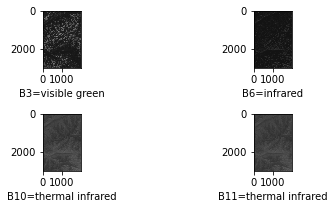

In [13]:
original_B3=io.imread("B3.tif")
img_B3=original_B3[3000:6000,3000:5000]
original_B6=io.imread("B6.tif")
img_B6=original_B6[3000:6000,3000:5000]
original_B10=io.imread("B10.tif")
img_B10=original_B10[3000:6000,3000:5000]
original_B11=io.imread("B11.tif")
img_B11=original_B11[3000:6000,3000:5000]

plt.subplot(3,2,1),io.imshow(img_B3),plt.xlabel('B3=visible green')
plt.subplot(3,2,2),io.imshow(img_B6),plt.xlabel('B6=infrared')
plt.subplot(3,2,3),io.imshow(img_B10),plt.xlabel('B10=thermal infrared')
plt.subplot(3,2,4),io.imshow(img_B11),plt.xlabel('B11=thermal infrared')

Calculation of the Top of Astmosphere reflectance:

In [3]:
#Landsat 8 metadata:
RADIANCE_MULT_BAND_10 = 0.0003342
RADIANCE_MULT_BAND_11 = 0.0003342

RADIANCE_ADD_BAND_10 = 0.1
RADIANCE_ADD_BAND_11 = 0.1

TOA= RADIANCE_MULT_BAND_10 *img_B10 + RADIANCE_ADD_BAND_10

Converting TOA to brightness

In [4]:
#From Landsat 8 metadata:
K1_10=774.8853
K2_10=1321.0789
K1_11=480.8883
K2_11=1201.1442

#Brightness Temperature Calculation:
BT_10=np.zeros([TOA.shape[0],TOA.shape[1]])
BT_11=np.zeros([TOA.shape[0],TOA.shape[1]])

for i in range (TOA.shape[0]):
    for j in range (TOA.shape[1]):
       
        BT_10[i,j] = (K2_10/(math.log(K1_10/TOA[i,j])+1))-273.15
        BT_11[i,j] = (K2_11/(math.log(K1_11/TOA[i,j])+1))-273.15

#K1 : band-specific thermal conversion constant obtained from the metadata
#K2 : "

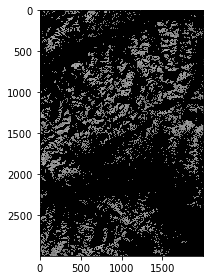

In [5]:
#Calculation of the NDSI

def calcul_NDSI(B3, B6): #Parameters : Image B3, Image B6
    
    B3 = np.array(B3, dtype=float)
    B6 = np.array(B6, dtype=float)
    
    b = B6 + B3
    a = B3 - B6
    
    ndsi_threshold = np.zeros(a.shape)
    ndsi = np.zeros(a.shape)
    
    ndsi_threshold[b>0] = a[b>0] / b[b>0]

    for i in range (0,ndsi_threshold.shape[0]):
        for j in range (0,ndsi_threshold.shape[1]):
            if ndsi_threshold[i,j]>0.4:
                ndsi[i,j]=ndsi_threshold[i,j]
            else:
                ndsi[i,j]=0
    return ndsi

NDSI=calcul_NDSI(img_B3,img_B6)
io.imshow(NDSI)

In [6]:
#Calculation of the proportion of snow Ps

NDSI_min=np.min(calcul_NDSI(img_B3,img_B6))
NDSI_max=np.max(calcul_NDSI(img_B3,img_B6))

Ps=np.zeros([NDSI.shape[0],NDSI.shape[1]])

for i in range (Ps.shape[0]):
    for j in range (Ps.shape[1]):
        Ps[i,j]=((NDSI[i,j]-NDSI_min)/(NDSI_max-NDSI_min))**2

In [7]:
#Calculation of the emissivity eps

eps=np.zeros([NDSI.shape[0],NDSI.shape[1]])

for i in range (eps.shape[0]):
    for j in range (eps.shape[1]):
        eps[i,j]=0.004*Ps[i,j]+0.986

In [18]:
#Calculation of the land surface temperature (LST)

hc=1.4388 #Planck constant C2
lamb=0.00115 #wavelenght

LST_10=np.zeros([BT_10.shape[0],BT_10.shape[1]])
LST_11=np.zeros([BT_11.shape[0],BT_11.shape[1]])

for i in range (BT_10.shape[0]):
    for j in range (BT_10.shape[1]):
        LST_10[i,j] = (BT_10[i,j]/(1+(lamb*BT_10[i,j]/hc)))*math.log(eps[i,j])
        LST_11[i,j] = (BT_11[i,j]/(1+(lamb*BT_11[i,j]/hc)))*math.log(eps[i,j])

plt.subplot(1,3,1),io.imshow(LST_10),plt.xlabel('LST10')
plt.subplot(1,3,2),io.imshow(LST_11),plt.xlabel('LST11')
plt.subplot(1,3,3),io.imshow(img_B10),plt.xlabel('B10')

(<AxesSubplot:xlabel='B10'>,
 Text(0.5, 50.17499999999998, 'B10'))

In [9]:
histogramme=plt.hist(LST_11)
plt.show(histogramme)